In [2]:

import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import anndata
import matplotlib.pyplot as plt

from matplotlib.pyplot import rc_context
import matplotlib.colors as mcolors

plt.rcParams['figure.dpi']=200


In [3]:
corr_df = pd.read_csv("Xe2vis_map_df_diameter_55um.csv", index_col=0)

In [4]:
xe_adata = sc.read_h5ad("../Xenium_all.h5ad")
xe_adata = xe_adata[xe_adata.obs.ident.isin(['ShamR','Hour4R','Hour12R', 'Day2R', 'Day14R', 'Week6R'])]
adata_vis = sc.read_h5ad("Visium_IRI_R.h5ad")
gene_overlap = [g for g in xe_adata.var_names.tolist() if g in adata_vis.var_names.tolist()]
print(len(gene_overlap))

295


### AGG gene expression

In [4]:
### aggregate gene expression
count_df = sc.get.obs_df(xe_adata, keys=gene_overlap, use_raw=True)
agg_gene = []

df_visium =  adata_vis.obs[["x_align","y_align"]]
df_visium["spot_id"] = df_visium.index.tolist()

for spot_id in df_visium['spot_id']:
    cells_in_spot = corr_df[corr_df['spot_id'] == spot_id]['cell_id']
    counts = count_df.loc[cells_in_spot.tolist(),]
    sum_counts = counts.sum(axis=0).to_numpy()
    agg_gene.append(sum_counts)

/tmp/ipykernel_20001/2239856565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_visium["spot_id"] = df_visium.index.tolist()


In [5]:
agg_gene_df = pd.DataFrame(agg_gene)
agg_gene_df.columns = gene_overlap
agg_gene_df.index = df_visium['spot_id']
agg_gene_df.fillna(0, inplace=True) 

In [6]:
Xenium_agg_gene_df = agg_gene_df.loc[:,gene_overlap]
Visium_gene_df = sc.get.obs_df(adata_vis, keys = gene_overlap, use_raw=True)
corr = pd.DataFrame(Xenium_agg_gene_df.corrwith(Visium_gene_df, method = "pearson",), columns = ["pearson_r"])
corr[corr["pearson_r"]<=0] = 0
corr = corr.fillna(0)
corr.sort_values(by = "pearson_r", ascending=False).head(30) 

,pearson_r
Plin2,0.818196
Krt20,0.804896
Cyp7b1,0.803579
Cd74,0.765200
Slc7a13,0.751740
Acsm3,0.744085
Slc12a1,0.720559
Smoc2,0.713355
Ptger3,0.708384
C3,0.708252


In [9]:
gene = "Acsm3"
xe_count_df = sc.get.obs_df(xe_adata, keys=gene, use_raw=True)
vis_count_df = sc.get.obs_df(adata_vis, keys=gene, use_raw=True)

agg_gene_df = []

for spot_id in adata_vis.obs.index:
    cells_in_spot = corr_df_new[corr_df_new['spot_id'] == spot_id]['cell_id']
    xe_counts = xe_count_df.loc[cells_in_spot.tolist(),]
    vis_counts = vis_count_df.loc[spot_id,]
    agg_gene_df.append([xe_counts.sum(),vis_counts])

In [11]:
df = pd.DataFrame(agg_gene_df)
df.loc[:,0].corr(df.loc[:,1])

0.7913564374566248

In [15]:
df['ident'] = adata_vis.obs['ident'].to_list()

In [19]:
corr_list = []
for id in df.ident.unique():
    df_tmp = df[df['ident']==id]
    corr_list.append(df_tmp.loc[:,0].corr(df_tmp.loc[:,1]))

In [23]:
corr_list

[0.9071379741473357,
 0.7183303806182839,
 0.8915835214196127,
 0.4557713285864878,
 0.8250752019728684,
 0.8720438094668919]

In [22]:
mean_corr = np.mean(corr_list)
std_corr = np.std(corr_list, ddof=1)  # ddof=1 for sample standard deviation
se_corr = std_corr / np.sqrt(len(corr_list))  # SE = SD / sqrt(N)
print(mean_corr)
print(se_corr)

0.7783237027019133
0.07024464318893642


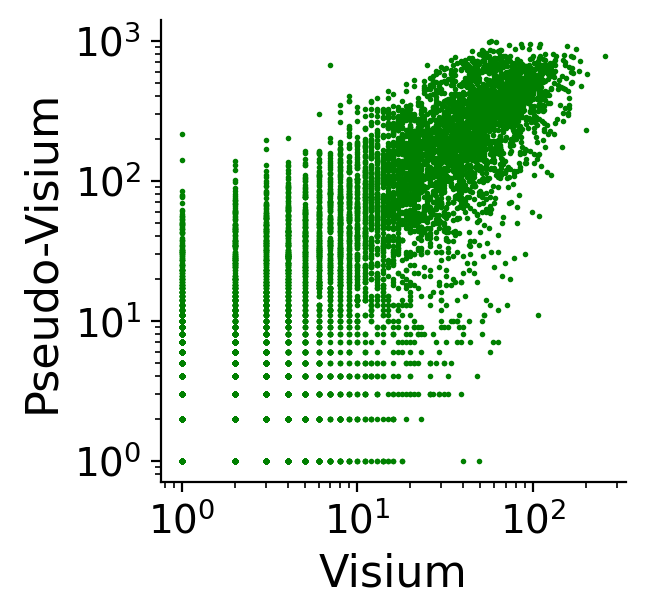

In [21]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 200)

ax.scatter(np.array(pd.DataFrame(agg_gene_df))[:,1], np.array(pd.DataFrame(agg_gene_df))[:,0], s = 1, color = "green")
ax.set_xlabel("Visium", fontsize=16) 
ax.set_ylabel("Pseudo-Visium", fontsize=16) 
ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
ax.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks

ax.spines[['right', 'top']].set_visible(False)
plt.savefig("Acsm3_corr.pdf", dpi=300, transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

In [27]:
median_gene_compare_df = pd.DataFrame({"Xenium":Xenium_agg_gene_df.mean(), "Visium":Visium_gene_df.mean()})

/tmp/ipykernel_51423/2872568326.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.annotate(annotation_text_4, xy=(x_point_4, y_point_4), xytext=(50, 25), color = "red", fontsize=14,


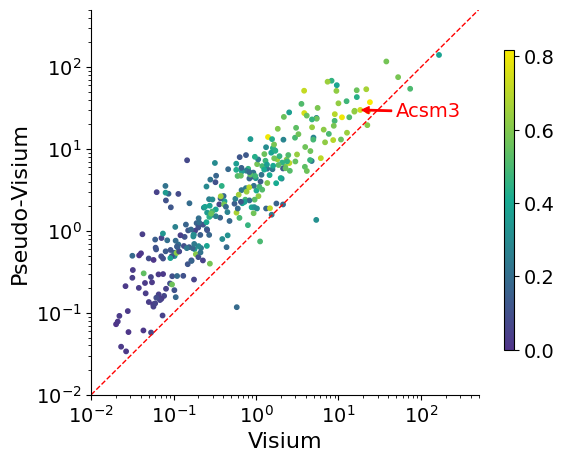

In [40]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("Viridis", ['#503489', '#18ab92', '#f9e900'])

corr = corr.loc[median_gene_compare_df.index,]
value = corr["pearson_r"].to_numpy()
norm = matplotlib.colors.Normalize(vmin=min(value), vmax=max(value))
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
all_colors = [to_hex(mapper.to_rgba(c)) for c in value]


x_point_4 = median_gene_compare_df["Visium"]["Acsm3"]
y_point_4 = median_gene_compare_df["Xenium"]["Acsm3"]
annotation_text_4 = "Acsm3"

fig, ax = plt.subplots(figsize = (5,5), dpi = 100)

ax.scatter(median_gene_compare_df["Visium"], median_gene_compare_df["Xenium"], s = 10, color = all_colors)
ax.plot([0.01, 500], [0.01, 500], linewidth=1, color='red', linestyle='--') 

ax.annotate(annotation_text_4, xy=(x_point_4, y_point_4), xytext=(50, 25), color = "red", fontsize=14,
            arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=5, headlength=5, color = "red"),)

ax.set_xlabel("Visium", fontsize=16) 
ax.set_ylabel("Pseudo-Visium", fontsize=16) 
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.01,500)
ax.set_ylim(0.01,500)

ax.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
ax.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks


ax.spines[['right', 'top']].set_visible(False)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cbar = fig.colorbar(mapper, ax=ax, orientation='vertical', cax=cbar_ax)

# Increase font size for colorbar ticks
cbar.ax.tick_params(labelsize=14)  # Adjust tick label size

#plt.tight_layout()
fig.savefig("Xenium_Pseudobulk_visium_Acsm3.pdf", dpi=300, transparent=True,  bbox_inches="tight", pad_inches=0)
plt.show()